# Import and variables

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import os
import io
import sys
import json
import tqdm
import math
import pickle
import urllib
import operator
import requests
import textwrap
import functools
import traceback
import itertools
import matplotlib
import contextlib
import numpy as np
import pandas as pd
from Bio import SeqIO
import seaborn as sns
import networkx as nx
import plotly.express as px
from functools import reduce
import matplotlib.pyplot as plt

from multiprocessing import Pool

from scipy import stats
from sklearn.preprocessing import minmax_scale

from pygosemsim import graph
from pygosemsim import download
from pygosemsim import term_set
from pygosemsim import similarity

from utilities.funcs import *

cwd = os.getcwd()
main_dir = 'testzenodo'
os.chdir(main_dir)

imgformat = 'pdf'

## Variables

In [2]:
goslim_subset = 'goslim_generic'
level = 'at2759'
gosource = 'experimental' # experimental, all or odb

odb_levels = 'https://v101.orthodb.org/download/odb10v1_levels.tab.gz'
levels = pd.read_table(odb_levels, compression='gzip', header=None)
levels[0] = levels[0].apply(lambda x: f'at{x}')
levels = dict(levels[[0,1]].values.tolist())
levelname = levels.get(level)
goaspects = ('P','C','F')

## File paths

In [3]:
# LINKS
zenodo_link = 'https://zenodo.org/record/7578797/files/' # or ''
odb_og2genes = 'https://v101.orthodb.org/download/odb10v1_OG2genes.tab.gz'
odb_genexrefs = 'https://v101.orthodb.org/download/odb10v1_gene_xrefs.tab.gz'

# INFILES


transitions_file = 'Eukaryota.raxml.RL.transitions.annotated'
clusters_raw_file = 'intersection.Eukaryota.raxml.RL.clusters.annotated'
rlcsv = 'Eukaryota.raxml.RL.csv'

if zenodo_link:
    
    transitions_file = zenodo_link+'Eukaryota.raxml.RL.transitions.annotated'
    clusters_raw_file = zenodo_link+'intersection.Eukaryota.raxml.RL.clusters.annotated'
    rlcsv = zenodo_link+'Eukaryota.raxml.RL.csv'
    
    !wget -q {clusters_raw_file}
    
# OUTFILES

clusters_file = f'{os.path.basename(clusters_raw_file)}.grouped'
allogs_file = f"{os.path.basename(transitions_file)}.ogs"

oguni_file = f'og_uni_{levelname}.tsv'
unigo_file = f'{os.path.basename(transitions_file)}.unigo'
oggo_file = f'{unigo_file}.{gosource}'
odbfile = f'{os.path.basename(transitions_file)}.odb.pickle'
odb_clusters_file = f'{clusters_file}.odb'

goobo_file = f'go.obo'

kegg_file = f'{os.path.basename(transitions_file)}.odb'
goslim_file = f'{oggo_file}.slim'
scores_file = f'{clusters_file}.{gosource}.scores'
boxcox_file = f"{oggo_file}.slim.boxcox"

pygosemsim_file = f'{os.path.basename(oggo_file)}.pygosemsim'

goslim_subset = 'goslim_generic.obo'
goslim_annotation = 'annotations.generic'

# Process input files

In [4]:
ognames = pd.read_table(rlcsv)
ognames = dict(ognames[['Orthogroup','Description']].values)

trans = pd.read_table(transitions_file)
trans['ogname1'] = trans['Orthogroup1'].apply(lambda x: ognames.get(x))
trans['ogname2'] = trans['Orthogroup2'].apply(lambda x: ognames.get(x))
trans = trans.dropna()
trans['ognames'] = trans.apply(lambda x: x['ogname1']+' --- '+x['ogname2'], axis=1)
trans = trans.drop(['ogname1','ogname2'], axis=1)
trans.to_csv(os.path.basename(transitions_file), sep='\t', index=None)
    
# processing raw clusters file --> dataframe
clustersfromann(os.path.basename(clusters_raw_file), level).to_csv(clusters_file, sep='\t', index=None)

# all ogs list
transitionsogs = transitionstoogs(os.path.basename(transitions_file))
allogsdf = transitionsogs[['og','ogname']]
allogsdf.columns = ['og','name']
allogsdf.to_csv(allogs_file, sep='\t', index=None)

# OrthoDB Annotations `ETA: ~1h`

In [5]:
download per each orthogroup all available databases annotations from orthodb
!python3 {cwd}/utilities/oginfo.py -i {allogs_file} -o {odbfile} -p 100

In [88]:
odbinfos = dict(pickle.load(open(odbfile, 'rb')))

# and store them in a dataframe
dfs = []
for o in tqdm.tqdm(odbinfos.keys()):
    data = odbinfos.get(o)
    if len(data)>0:
        data = data['data']
        keys = [k for k in data.keys() if type(data.get(k)) == list]
        if len(keys)>0:
            dfs.append(pd.concat([pd.json_normalize(data.get(k)).assign(db=k) 
                            for k in keys]).assign(og=o))

dfsodbinfo = pd.concat(dfs).drop(['name','type','count'], 
                          axis=1).reset_index(drop=True)

100%|██████████| 46954/46954 [01:43<00:00, 452.57it/s]


# GO

## mapping all GO from UniProt `ETA: ~1h`

In [ ]:
!curl -L https://ftp.ebi.ac.uk/pub/databases/GO/goa/old/UNIPROT/goa_uniprot_all.gaf.211.gz -o goa_uniprot_all.gaf.gz

goa = 'goa_uniprot_all.gaf.gz'
xref = pd.read_table(odb_og2genes, compression='gzip', header=None)
og2genes = pd.read_table(odb_genexrefs, compression='gzip', header=None)
og2genes = og2genes[og2genes[2]=='UniProt']
merged = pd.merge(og2genes, xref.rename(columns={0:3,1:0}))
merged2 = merged[merged[3].str.endswith(level)]
merged2.columns = ['gene','id','db','og']
merged2.to_csv(oguni_file, sep='\t', index=None) # og_uni_Eukaryota.tsv

!python3 {cwd}/utilities/oguni2chunk.py {goa} {oguni_file} {unigo_file} 20

## Filter on gosource

In [7]:
ratio = 0.0 ## remove GO term less then ratio percent of the most frequent term for each OG for each aspect

if gosource == 'all':
    oggo = pd.read_table(unigo_file)
    oggo = oggo[oggo['ratio']>=ratio]
    oggo[~oggo['go'].isin(['GO:0008150', 'GO:0005575', 'GO:0003674','GO:0005515'])
        ].to_csv(oggo_file, 
                 sep ='\t', index=False)

elif gosource =='experimental':    
    oggo = pd.read_table(unigo_file)
    # ex = ['IDA', 'IMP', 'IPI', 'IEP', 'IGI']
    ex = ['EXP','IDA', 'IMP', 'IPI', 'IEP', 'IGI',
          'HTP','HDA','HMP','HGI','HEP','IC','TAS']
    ############################
    oggo['evidence'] = oggo['evidence'].apply(eval)
    oggo['uni'] = oggo['uni'].apply(eval)
    oggo = oggo.reset_index().set_index(['index']).apply(pd.Series.explode)
    oggo = oggo[oggo['evidence'].isin(ex)]
    oggo = oggo[oggo['ratio']>=ratio]
    oggo = oggo[~oggo['go'].isin(['GO:0008150', 'GO:0005575', 'GO:0003674', 'GO:0005515'])]
    evi_uni = pd.merge(oggo.groupby(['og', 'go'])['evidence'].apply(list).reset_index(),
                     oggo.groupby(['og', 'go'])['uni'].apply(list).reset_index())
    oggo = evi_uni.merge(oggo.drop(['evidence', 'uni'], axis=1), on=['og', 'go'])
    oggo.to_csv(oggo_file, 
                 sep ='\t', index=False)
    ############################
#     oggo = oggo[oggo['evidence'].str.contains('|'.join(ex))]
#     oggo = oggo[oggo['ratio']>=ratio]
#     oggo[~oggo['go'].isin(['GO:0008150', 'GO:0005575', 'GO:0003674', 'GO:0005515'])
#         ].to_csv(oggo_file, 
#                  sep ='\t', index=False)

if gosource == 'odb':

    dfs = dfsodbinfo[['og', 'id', 'db']]
    dfs['evidence'] = 'ODB'
    dfss = dfs[dfs['db'].str.contains('_')][dfs['id'].str.contains('GO')]
    dfss['db'] = dfss['db'].apply(lambda x: x.split('_')[1][0].upper())
    dfss.columns = ['og','go','type','evidence']
    dfss.to_csv(oggo_file, sep='\t', index=None)

## PyGOSemSim `ETA: ~30 min`

In [21]:
processes = 500

# download GO network graph and build it
try:
    download.obo("go-basic")
except ValueError:
    pass
download.download("goslim_chembl.obo",
    "http://www.geneontology.org/ontology/subsets/goslim_chembl.obo")
G = graph.from_resource("go-basic")
G_chembl = graph.from_resource("goslim_chembl")
similarity.precalc_lower_bounds(G)

def calcsim(indexgo1go2):
    ''' given two set of GOs calculates the similarity score using the Resnik approach '''
    try:
        sf = functools.partial(term_set.sim_func, 
                               G, similarity.resnik)
        si = term_set.sim_bma(indexgo1go2[1], 
                              indexgo1go2[2], sf)
    except:
        si = 0
    return [indexgo1go2[0], si]

# open transitions file and GO file and
transitions = pd.read_table(os.path.basename(transitions_file))
oggo_df = pd.read_table(oggo_file)
# separate the three GO aspect
oggo = dict(oggo_df.groupby('og')['go'].apply(
    lambda x: list(set(x))).reset_index().values)
oggo_bp = dict(oggo_df[oggo_df['type']=='P'].groupby('og')[
    'go'].apply(lambda x: list(set(x))).reset_index().values)
oggo_cc = dict(oggo_df[oggo_df['type']=='C'].groupby('og')[
    'go'].apply(lambda x: list(set(x))).reset_index().values)
oggo_mf = dict(oggo_df[oggo_df['type']=='F'].groupby('og')[
    'go'].apply(lambda x: list(set(x))).reset_index().values)

dfs = []
for OGGO, typ in zip([oggo_bp, oggo_cc, oggo_mf],
                     ['BP', 'CC', 'MF']):
    # group pairs of orthogroups GOs
    oggo_df = transitions[['Orthogroup1','Orthogroup2']].applymap(
        lambda x: OGGO.get(x)).reset_index()
    oggo_df.columns = ['index','go1', 'go2']
    oggo_df = oggo_df.dropna()
    # calculate the similarity score
    simscore = Pool(processes).map(calcsim, oggo_df.values.tolist())
    simscore = dict(simscore)
    oggo_df['simscore'] = oggo_df['index'].apply(
        lambda x: simscore.get(x))
    oggo_df = oggo_df.drop('index', axis=1)
    # renaming columns
    oggo_df = oggo_df.reset_index(drop=True).rename(
        columns={'simscore':f'{typ.lower()}sim', 
                 'go1':f'go1_{typ.lower()}', 
                 'go2':f'go2_{typ.lower()}'})
    oggo_df[f'len_go1_{typ.lower()}'] = oggo_df[
        f'go1_{typ.lower()}'].apply(len)
    oggo_df[f'len_go2_{typ.lower()}'] = oggo_df[
        f'go2_{typ.lower()}'].apply(len)
    dfs.append(pd.concat([transitions.loc[
        list(simscore.keys())].reset_index(drop=True), 
                          oggo_df], axis=1))

# store all the informations in a file.pygosemsim
total = (dfs[0]
 .merge(dfs[1], how='outer')
 .merge(dfs[2], how='outer')
)
total.to_csv(pygosemsim_file, sep='\t', index=False)

Download started: http://www.geneontology.org/ontology/subsets/goslim_chembl.obo
Downloaded 0.3MB of 0.3MB (100.0 %)
Download finished: goslim_chembl.obo (0.3) MB
format-version: 1.2
format-version: 1.2


In [27]:
oggo_file

'Eukaryota.raxml.RL.transitions.annotated.unigo.experimental'

### Figure 3A

In [22]:
df = pd.read_table(pygosemsim_file)

# set up a progressive pvalue cutoffs list (one for each step)
ths = list(reversed(list(map(lambda x: 10**(-x/100), 
                             range(0,2000,100)))[3:]))[:-1]
# separate the entire set in chunks using the pvalue cutoffs
chunks, ts = [],[]
for n, t in   enumerate(ths):
    if n == 0:
        chunk = df[df['p']<=t]
    elif n == len(ths)-1:
        chunk = df[df['p']>t]
    else:
        try:
            chunk = df[df['p'].between(t, ths[n+1], inclusive='left')]
        except:
            pass
    chunks.append(chunk)
    ts.append("{:.0e}".format(t))

# build the dataframe for the next cell (scatter plot)
n = 0
columns = df.columns[df.columns.str.contains('sim')]
# lens = list(map(lambda x: len(x), chunks))*len(columns)
lens = [[len(chunks[ii][(chunks[ii][f"len_go1_bpsim".replace('sim', '')]>=n)&
             (chunks[ii][f"len_go2_bpsim".replace('sim', '')]>=n)
                       ].dropna(subset=['bpsim'])), 
         len(chunks[ii][(chunks[ii][f"len_go1_ccsim".replace('sim', '')]>=n)&
             (chunks[ii][f"len_go2_ccsim".replace('sim', '')]>=n)
                       ].dropna(subset=['ccsim'])), 
         len(chunks[ii][(chunks[ii][f"len_go1_mfsim".replace('sim', '')]>=n)&
             (chunks[ii][f"len_go2_mfsim".replace('sim', '')]>=n)
                       ].dropna(subset=['mfsim']))] 
        for ii in range(len(chunks))]

lens = list(itertools.chain(*pd.DataFrame(lens).T.values.tolist()))

scatter, line = [], []

for column in columns:
    name = column.rstrip('sim').upper()
    # # c = 100
    df1 = df[(df[f"len_go1_{column}".replace('sim', '')]>=n)&
             (df[f"len_go2_{column}".replace('sim', '')]>=n)]
    # calculate the fraction > mean score of each chunk
    ser = pd.Series([len(d[d[column]>=df1[column].mean()][
        (d[f"len_go1_{column}".replace('sim', '')]>=n)&
             (d[f"len_go2_{column}".replace('sim', '')]>=n)])
                     /len(d[(d[f"len_go1_{column}".replace('sim', '')]>=n)&
             (d[f"len_go2_{column}".replace('sim', '')]>=n)
                           ].dropna(subset=[column]))#len(d)
                     if len(d) != 0 else 0 
                     for d in chunks]).reset_index()
    
    ser['type'] = name
    ser['slices'] = ts
    scatter.append(ser)

lab = 'Fraction > mean score'
data = pd.concat(scatter).reset_index(drop=True)
data = data.rename(columns={0: lab})
data['slices'] = data['slices'].astype(str)
data['lengths'] = lens
data.columns = ['Index','Fraction > mean score', 
                'GO class', 'Slice', 'Numerosity']
# convert numerosity column values in log(numerosity) 
# for a better scatter plot readability
data['Log(N)'] = data['Numerosity'].apply(lambda x: np.log10(x))

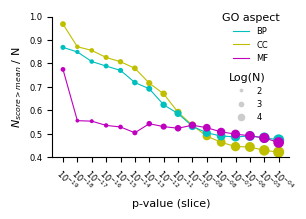

In [23]:
save = True
factor = 3.1/4

# set up standard parameters for the plot
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

# build the figure
fig, ax = plt.subplots(figsize=(3.1, 2.2), dpi=100) 

# iterate for each GO aspect, assign them an order priority (zo) and color (col)
for typ, col, zo in zip(['CC','BP','MF'],[(0.75,0.75,0),
                                          (0,0.75,0.75),
                                          (0.75,0,0.75)],
                        [1,2,3]):

    plt.plot(data[data['GO class']==typ]['Slice'], 
             data[data['GO class']==typ][lab], 
             label=typ, color=col, zorder=zo)
    plt.scatter(data[data['GO class']==typ]['Slice'], 
                data[data['GO class']==typ][lab], 
                label=typ, color=col, linewidths=0,
                sizes=[i*factor*i*factor*math.pi 
                       for i in data[data['GO class']==typ
                                    ]['Log(N)']], zorder=zo)

# convert the sizes in area for the scatter plot (for better readability)
scatter = plt.scatter([0,1,2], [0,1,2], color=(1,1,1),
                  sizes=[x*factor*x*factor*math.pi 
                         for x in (2,3,4)], zorder=0)

# build the two legends, one for the GO aspect and the other for the log(N)
handles, labels = ax.get_legend_handles_labels()
hl = sorted(zip(handles, labels), key=operator.itemgetter(1))
hl = [hl[0],hl[2],hl[4]]
handles2, labels2 = zip(*hl)
legend3 = ax.legend(handles2, labels2, loc=(0.7,0.65), 
                    title='GO aspect', frameon=False)

handles, labels = scatter.legend_elements(
    prop="sizes", alpha=0.2, markeredgewidth=0)
labels = [2,3,4]
legend2 = ax.legend(handles, labels, loc=(0.73,0.23), 
                    title="Log(N)", frameon=False)
plt.gca().add_artist(legend3)

# other plot adjustments
plt.xticks(rotation=-45, ha="left", rotation_mode="anchor")
ax.spines[['top', 'right']].set_visible(False)

plt.xlabel("p-value (slice)")
plt.ylabel("$N_{score>mean}$ / N")

ax.set_xticklabels(labels=["$10^{-tag}$".replace(
    'tag', str(s).split('-')[1]) for s in 
                           data[data['GO class']==typ]['Slice']])

plt.ylim(0.4,1)
if save:
    fig.tight_layout()
    fig = ax.get_figure()
    fig.savefig(f'{pygosemsim_file}.{imgformat}', dpi=300)

## GO SLIM

In [28]:
# download the entire GO network in .obo format
!curl -L http://purl.obolibrary.org/obo/go.obo -o go.obo
# download the slimming tool and give it the executing permissions
!curl -L https://github.com/owlcollab/owltools/releases/download/2020-04-06/owltools -o owltools
!chmod +x owltools

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   316    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 32.4M  100 32.4M    0     0   445k      0  0:01:14  0:01:14 --:--:--  423k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 36.8M  100 36.8M    0     0  8054k      0  0:00:04  0:00:04 --:--:-- 11.3M


In [29]:
# retrieve all GOs available from go.obo file
mini, minimini = [], []
for line in open(os.path.basename(goobo_file)).readlines()[29:]:
    if line.startswith('id: GO'):
        mini.append(minimini)
        minimini = []
    minimini.append(line)
gos = pd.DataFrame([[m[0].strip().split('id: ')[1],
                     m[1].strip().split('name: ')[1],
                     m[2].strip().split('namespace: ')[1]] 
                    for m in mini[1:]]).drop_duplicates(0)
gos = gos[~gos[1].str.contains('obsolete')]
gos = gos.reset_index(drop=True).reset_index()
gos.columns = ['index','go','goname','gotype']
gos['gotype'] = gos['gotype'].apply(lambda x: 
                                    'P' if 'biological' in x else 
                                    'F' if 'molecular' in x else 
                                    'C' if 'component' in x else None)
gonames = dict(gos[['go','goname']].values)
gotypes = dict(gos[['go','gotype']].values)

# GO -> GO slim using OWLTOOLS (https://github.com/owlcollab/owltools)
def gostoslim(goobo, outfile, subset, gos):

    print('!gaf-version: 2.0', file=open(outfile, 'w'))
    for row in gos.values.tolist():
        a = list(map(str, [' ']*16))
        a[1], a[4] = str(row[0]), row[1]
        print('\t'.join(a), file=open(outfile, 'a'))

    with contextlib.redirect_stdout(io.StringIO()):
        !owltools {goobo} --gaf {outfile} --map2slim --subset {subset} --write-gaf {outfile}

    slim = pd.read_table(outfile, comment='!', header=None)
    slim = slim[[1,4]]
    slim.columns = ['index','go']
    slim['index'] = slim['index'].apply(lambda x: int(x[1:]))

    return slim

slim = gostoslim(os.path.basename(goobo_file), goslim_annotation, 
                 os.path.basename(goslim_subset.replace('.obo', '')
                            ), gos).assign(db=goslim_subset)

# re-mapping any missing goslim_generic to goslim_PIR (more specific)
if 'generic' in goslim_subset:    
    missing = pd.merge(gos.rename(columns={0:'go'}), 
                       slim.rename(columns={'go':'goslim'}),how='outer')
    missing = missing[missing['goslim'].isna()][['index','go']]

    slim_pir = gostoslim(os.path.basename(goobo_file), goslim_annotation.replace('.generic', '.pir'), 
                      os.path.basename(goslim_subset.replace(
                          '_generic.obo', '_pir')), missing
                     ).assign(db=goslim_subset.replace(
        '_generic.obo', '_pir'))
    final = pd.merge(gos, pd.concat(
        [slim, slim_pir]).rename(
        columns={'go':'goslim'}),on='index',how='outer').dropna()
    final['goslimname'] = final['goslim'].apply(lambda x: gonames.get(x))
    final['goslimtype'] = final['goslim'].apply(lambda x: gotypes.get(x))
    slim = final

slim = slim[['go','gotype','goname','goslim','goslimtype','goslimname','db']]
slim.to_csv(f'{goslim_annotation}.tsv', index=None, sep='\t')

### Orthogroups GO slim mapping

<AxesSubplot:ylabel='Frequency'>

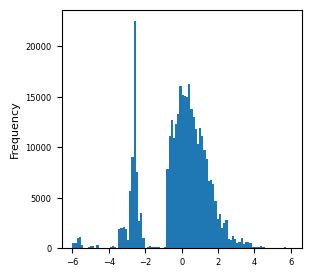

In [56]:
ogunigo = pd.read_table(oggo_file)
slim = pd.read_table(f'{goslim_annotation}.tsv')

ogunigoslim = pd.merge(ogunigo, slim, how='outer'
                      ).dropna().drop_duplicates()
ogunigoslim.to_csv(f'{oggo_file}.slim', 
                  sep='\t', index=None)

transitionsogs = transitionstoogs(os.path.basename(transitions_file))
goslim = pd.read_table(f'{oggo_file}.slim')

singlego = pd.merge(transitionsogs, goslim, on='og')
singlego = singlego.drop_duplicates([
    'og','goname','goslimname'])

# exclude macro GO classes
# singlego = singlego[~singlego['goslim'].isin(['GO:0008150', 'GO:0005575', 'GO:0003674','GO:0005515'])]
# 'protein binding'])] ######################################################################## rimosso anche protein binding, per fare una prova

# transitions pvalue to -log10 pvalue
singlego['log10pval'] = singlego['p'].apply(
    lambda x: -np.log10(x))
singlego['log10adjpval'] = singlego['p.adj'].apply(
    lambda x: -np.log10(x))
final = singlego.reset_index(drop=True).sort_values(
   'log10pval', ascending=False)

final['log10pvalscaled'] = minmax_scale(stats.boxcox(final['log10pval'].values, -0.5), feature_range=(-6,6))

final.to_csv(f'{boxcox_file}', sep='\t', index=None)

final['log10pvalscaled'].plot.hist(bins=100, figsize=(3.1,3.1))


### Orthogroup ranking files

In [58]:
# write a pval based ranking file containing orthogroups and their GO annotations
for goclass in goaspects:
    finalfilt = final[final['goslimtype']==goclass]
    finalfilt = finalfilt[['og','log10pvalscaled',
                           'goslim','goslimname',
                           'ogname']]
    finalfilt.columns = ['name','score','feature',
                         'description','extraname']
    finalfilt.drop_duplicates(['name','feature',
                               'description']
        ).to_csv(f"{boxcox_file}.{goclass}.ranking", 
                         sep='\t', index=None)

### GO Enrichment

In [59]:
# enrichemnt analysis using clusterProfiler library in R (https://github.com/YuLab-SMU/clusterProfiler)
for goclass in goaspects:
    file = f"{boxcox_file}.{goclass}.ranking"
    !Rscript {cwd}/utilities/enrich.R --input_file {file} --pval_cutoff 1


Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun
clusterProfiler v4.2.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching package: ‘rlang’

The following object is masked from ‘package:data.table’:

    :=

preparing geneSet collections..

### Figure 3B and supplementary figures S11

In [60]:
# buil personalized colormaps for project uniformity
colorsfrommap = [plt.cm.jet(n)[0:3] for n in np.array(list(range(0,12)))/11]
newcolors = np.array([(0.75,0.75,0,i/255) for i in range(255)])
newcmp1 = matplotlib.colors.ListedColormap(newcolors)
newcolors = np.array([(0,0.75,0.75,i/255) for i in range(255)])
newcmp2 = matplotlib.colors.ListedColormap(newcolors)
newcolors = np.array([(0.75,0,0.75,i/575) for i in range(255)])
newcmp3 = matplotlib.colors.ListedColormap(newcolors)

# define a set of parameters for project uniformity
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

def plotenrichment(enrfile, rankfile, enrSize, colormap, title, 
                   pvalthreshold, genesizelimit, save=False, figsize=(4.2,4)):
    
    def customwrap(s, width=40):
        ''' will add a \n between defined string widths '''
        return "\n".join(textwrap.wrap(s,width=width))

    df = pd.read_table(enrfile, sep=',').drop(
        'Unnamed: 0', axis=1).dropna()

    # pvalue cutoff
    df = df[df['pvalue']<=pvalthreshold]
    df = df.sort_values('NES', ascending=False)
    df = pd.concat([df[df['NES']>=0].head(enrSize), df[df['NES']<0].tail(enrSize)])
    df = df.reset_index(drop=True)
    
    # to abbreviate descriptions
    df['Description'] = df['Description'].apply(
        lambda x: 'nucleobase-cont. small mol. met. proc.' if 'nucleobase-containing small molecule metabolic process' in x 
        else 'gen. of precursor metabol. and energy' if 'generation of precursor metabolites and energy' in x
        else x)
    
    df['Description'] = df['Description'].apply(lambda x: customwrap(x))

    # extract core_enrichment orthogroups id and conversion in descriptions
    df['core_enrichment'] = df['core_enrichment'].apply(lambda x: x.split('/'))
    ognames = dict(pd.read_table(rankfile).drop_duplicates(
        'name')[['name','extraname']].values)
    df['core_enrichment_names'] = df['core_enrichment'].apply(
        lambda x: [ognames.get(i) for i in x])
    df['coreSize'] = df['core_enrichment'].apply(len)
    # coresize upper bounds scaling
    
    genesizelimit = int(df['coreSize'].median())
    if genesizelimit <= 50:
        genesizelimit = genesizelimit-genesizelimit%10+10
    else:
        genesizelimit = genesizelimit-genesizelimit%50+50
    # genesizelimit=300
    df['coreSizenorm'] = df['coreSize'].apply(
        lambda x: genesizelimit if x>=genesizelimit else x)
    fig, (cax,ax) = plt.subplots(ncols=2, figsize=figsize, dpi=100, 
                                 gridspec_kw={'width_ratios':[0.05, 1]})

    x = df['Description'].values
    ##########
    # x = df['Description'].values.tolist()+[' ','  ','   ']
    ##########
    # x = np.array(['nucleob.-containing small mol. metabolic process' 
    #               if 'nucleobase-containing small molecule metabolic process' 
    #               in i else i for i in x])
    y = df['NES'].values
    ##########
    # y = df['NES'].values.tolist()+[0,0,0]
    ##########
    c = df['coreSizenorm'].values

    colmap = colormap
    colors1 = colmap(c/c.max())
    sm = plt.cm.ScalarMappable(cmap=colmap, 
                               norm=plt.Normalize(vmin=c.min(), vmax=c.max()))

    # build the core_enrichment color bar
    cbar = plt.colorbar(sm, cax)
    cbar.set_ticks(list(range(0,genesizelimit+1,int(genesizelimit/5))))
    cbar.set_ticklabels(list(range(
        0,genesizelimit,int(genesizelimit/5)))+[f'>{genesizelimit}'])
    cbar.outline.set_linewidth(0.8)
    cbar.set_label('core enrichment', loc='top', fontsize=6)

    # other adjustments
    ax.barh(x, y, color=colors1, edgecolor = colormap.colors[-1])
    ax.yaxis.tick_right()
    ax.tick_params(axis='both', which='major')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines[['right','bottom']]
    ax.set_xlim(-5, 5)
    ax.set_xlabel('NES')

    cax.yaxis.tick_left()
    cax.tick_params(axis='both', which='major')

    plt.gca().invert_yaxis()
    plt.show()
    fig.tight_layout()

    if save == True:
        fig.savefig(f'{enrfile}.{imgformat}', dpi=300)

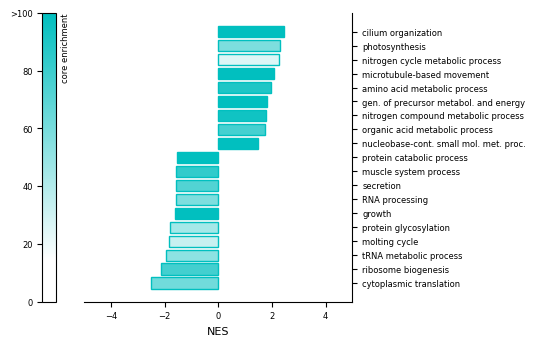

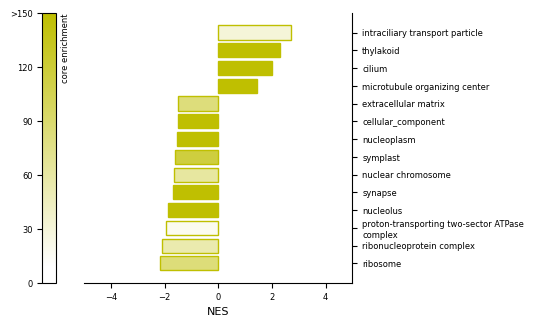

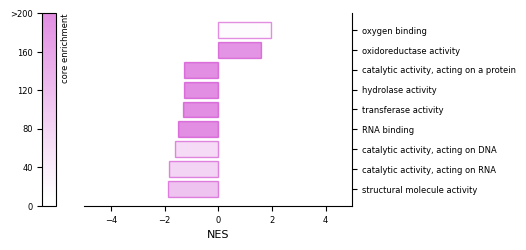

In [86]:
pval = 0.001
maxgr = 10
save = True
enrSize = 10

for goclass in ['P','C','F']:
    
    rankfile = f"{boxcox_file}.{goclass}.ranking"
    enrfile = f"{rankfile}.enriched"

    figsize= (4,3.75) if goclass == 'P' else (4,2.5) if goclass == 'F' else (4,3.5) if goclass == 'C' else (4,4)
    plotenrichment(enrfile, rankfile, enrSize, newcmp1 if goclass == 'C' 
                   else newcmp2 if goclass == 'P' else newcmp3, 
                   'NES BP' if goclass == 'P' else 'NES CC' 
                   if goclass == 'C' else 'NES MF', pval, maxgr, save, figsize=figsize)

# KEGG

In [89]:
clusters = pd.read_table(clusters_file)

# add orthodb annotations to each transitions
transitionsogs = transitionstoogs(os.path.basename(transitions_file))
odbtransitions = pd.merge(dfsodbinfo, transitionsogs, on='og')[['description','id','db','og','ogname']]

odbtransitions = pd.merge(odbtransitions, clusters[['og','cluster']], on='og', how='outer')
odbtransitions.to_csv(kegg_file, sep='\t', index=None)

# same to each clusters
odbclusters = pd.merge(dfsodbinfo, clusters[['cluster','n','og','name']])[['description','id','db','og','name','cluster','n']]
odbclusters.to_csv(odb_clusters_file, sep='\t', index=None)

## Enrich KEGG

<AxesSubplot:ylabel='Frequency'>

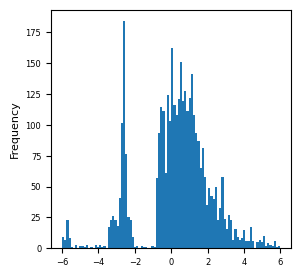

In [90]:
transitionsogs = transitionstoogs(os.path.basename(transitions_file))

# filter kegg ids (e.g. metabolism)
filton = '00'
# filter out KEGG macro classes
filterkegg = ['Metabolic pathways']

kegg = pd.read_table(kegg_file)
kegg = kegg.drop_duplicates(['og','id'])
kegg = kegg[(kegg['db'].str.contains('KEGG'))&~(kegg['description'].isin(filterkegg))]
kegg = kegg[kegg['id'].apply(lambda x: re.split('(\d+)', x)[1]).str.startswith(filton)] if filton else kegg

transitionsogskegg = pd.merge(transitionsogs, kegg, on=['og'])
transitionsogskegg['log10pval'] = transitionsogskegg['p'].apply(lambda x: -np.log10(x))
transitionsogskegg['log10adjpval'] = transitionsogskegg['p.adj'].apply(lambda x: -np.log10(x))

transitionsogskegg = transitionsogskegg.reset_index(drop=True).sort_values('log10pval', ascending=False)

from scipy import stats
from sklearn.preprocessing import minmax_scale
transitionsogskegg['log10pvalscaled'] = minmax_scale(stats.boxcox(transitionsogskegg['log10pval'].values, -0.5), feature_range=(-6,6))

transitionsogskegg.to_csv(f'{kegg_file}.kegg.boxcox', sep='\t', index=None)

transitionsogskegg['log10pvalscaled'].plot.hist(bins=100, figsize=(3.1,3.1))

### KEGG ranking file

In [91]:
transitionsogskeggfilt = transitionsogskegg[['og','log10pvalscaled','id','description','ogname_x']]
transitionsogskeggfilt.columns = ['name','score','feature','description','extraname']

transitionsogskeggfilt.to_csv(f'{kegg_file}.kegg.boxcox.ranking', sep='\t', index=None)

### KEGG Enrichment

In [92]:
file = f'{kegg_file}.kegg.boxcox.ranking'
!Rscript {cwd}/utilities/enrich.R --input_file {file} --pval_cutoff 1


Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun
clusterProfiler v4.2.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching package: ‘rlang’

The following object is masked from ‘package:data.table’:

    :=

preparing geneSet collections..

### Figure 3E

In [93]:
enrfile = f'{file}.enriched'

en = pd.read_csv(enrfile)
en['Description'] = en['Description'].apply(lambda x: x.split(',')[0] if '=' in x else x)
en['Description'] = en['Description'].apply(lambda x: x.replace('Glycosaminoglycan', 'GAG'))
en['Description'] = en['Description'].apply(lambda x: x.replace('Glycosphingolipid', 'GSL'))
en['Description'] = en['Description'].apply(lambda x: x.replace('Sesquiterpenoid and triterpenoid', 'Sesqui/Tri-terpenoid'))
en['Description'] = en['Description'].apply(lambda x: x.replace('heparan sulfate', 'HS'))
en['Description'] = en['Description'].apply(lambda x: x.replace('lacto and neolacto series', 'lacto/neolacto-series'))
en['Description'] = en['Description'].apply(lambda x: 'Phe, Tyr and Trp biosynthesis' if 'Phenylalanine, tyrosine' in x else x)
en['Description'] = en['Description'].apply(lambda x: 'Val, Leu and Ile degradation' if 'Valine, leucine' in x else x)
en.to_csv(enrfile, index=False)

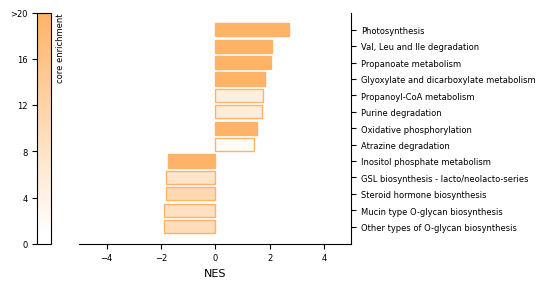

In [113]:
colorsfrommap = [plt.cm.jet(n)[0:3] for n in np.array(list(range(0,12)))/11]
viridis = plt.cm.get_cmap('viridis', 256)
newcolors = np.array([(1,0.7,0.4,i/255) for i in range(255)])
newcmp3 = matplotlib.colors.ListedColormap(newcolors)

# define a set of parameters for project uniformity
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

colorsfrommap = [plt.cm.jet(n)[0:3] for n in np.array(list(range(0,12)))/11]
viridis = plt.cm.get_cmap('viridis', 256)
newcolors = np.array([(1,0.7,0.4,i/255) for i in range(255)])
newcmp3 = matplotlib.colors.ListedColormap(newcolors)

enrfile = f'{file}.enriched'
pval = 0.01
maxgr = 20
enrSize = 20
save = True
figsize = (4.05,3)

plotenrichment(enrfile, file, enrSize, newcmp3,  f'NES KEGG Meta', pval, maxgr, save, figsize)

# Clusters analysis

## Clusters scores

In [95]:
# columns = description, id, db, og

# filter kegg ids (e.g. metabolism)
filton = '00'
# filter out kegg macro classes
filterkegg = ['Metabolic pathways']
# filter out go macro classes
filtergo = ['biological process','molecular function','cellular component', 'protein binding']

In [96]:
clusters = pd.read_table(clusters_file)

kegg = pd.read_table(odb_clusters_file)
kegg = kegg.drop_duplicates(['og','id'])
kegg = kegg[(kegg['db'].str.contains('KEGG'))]
# filter out kegg 'Metabolic pathways'
kegg = kegg[~(kegg['description'].isin(filterkegg))]

# selecting only KEGG metabolism pathway
keggmeta = kegg[kegg['id'].apply(lambda x: re.split('(\d+)', x)[1]).str.startswith(filton)]

goslim = pd.read_table(goslim_file)
goslim['ogname'] = goslim['og'].apply(lambda x: ognames.get(x, ''))
goslim = goslim[~goslim['goslimname'].isin(filtergo)]

In [97]:
def groupfeatures(df, tag):
    ''' for each user defined feature, calculates for each cluster the percentage of most frequent ones '''

    dfs = []
    for c in set(df['cluster']):

        dfc = df[df['cluster']==c].drop_duplicates()

        dfes, dnas = [], []
        for f in set(dfc['feature']):
            dfe = dfc[dfc['feature']==f]
            dfes.append((dfe.iloc[0]['feature'], len(dfe)))
            dnas.append((dfe.iloc[0]['featurename'], len(dfe)))

        dfcfeat = pd.DataFrame(dfes, columns = ['feature', 'og'])
        dfcnames = pd.DataFrame(dnas, columns = ['featurename', 'og'])

        features = ' --- '.join(dfcnames.sort_values('og', ascending=False)['featurename'].values)
        frequencies = ' --- '.join(map(str, dfcnames.sort_values('og', ascending=False)['og'].values))
        annotatedogs = len(list(set(dfc['og'])))
        population = dfc['n'].iloc[0]
        frequency = dfcfeat.max()['og']
        mostfreqfeat = ' --- '.join(dfcfeat[dfcfeat['og']==frequency]['feature'].tolist())
        mostfreqname = ' --- '.join(dfcnames[dfcnames['og']==frequency]['featurename'].tolist())
        
        # at least 2 og annotated
        score = round(frequency/annotatedogs, 2) if not annotatedogs <= 1 else 0

        dfs.append([c, population, tag, annotatedogs, frequency, score, 
                    mostfreqname, mostfreqfeat, features, frequencies])

    columns = ['cluster','pop','db','pop.ann','n.mostfreq','score',
               'mostfreq','mostfreqfeat','allfeat','n.allfeat']
    
    return pd.DataFrame(dfs, columns = columns)

# standardize datasets header
go = goslim[['og','ogname','goslim','goslimname','goslimtype']]
go.columns = ['og','ogname','feature','featurename','type']

ognames = dict(clusters[['og','name']].values)

# all keggs available
kegg['ogname'] = kegg['og'].apply(lambda x: ognames.get(x))
kegg = kegg[['og','ogname','id','description']].assign(type='K')
kegg.columns = ['og','ogname','feature','featurename','type']

# only metabolism associated kegg 
keggmeta['ogname'] = keggmeta['og'].apply(lambda x: ognames.get(x))
keggmeta = keggmeta[['og','ogname','id','description']].assign(type='Km')
keggmeta.columns = ['og','ogname','feature','featurename','type']

dfK = groupfeatures(pd.merge(clusters, kegg, on='og'), 'K')
dfKm = groupfeatures(pd.merge(clusters, keggmeta, on='og'), 'Km')
dfP = groupfeatures(pd.merge(clusters, go[go['type']=='P'], on='og'), 'P')
dfF = groupfeatures(pd.merge(clusters, go[go['type']=='F'], on='og'), 'F')
dfC = groupfeatures(pd.merge(clusters, go[go['type']=='C'], on='og'), 'C')
# string = pd.read_table(f'{string_outfile}.networkx')

# final = pd.concat([dfK,dfKm,dfP,dfF,dfC,string]).sort_values(
final = pd.concat([dfK,dfKm,dfP,dfF,dfC]).sort_values(
    ['cluster','db'], ascending=[True,False])
final['score'] = [x[1] if x[0] >1 else 0
                  for x in final[['n.mostfreq','score']
                                ].values.tolist()]

clusters = clusters.dropna(subset=['cluster','n','og','name'])
cluog = dict(clusters.groupby('cluster')['og'].apply(list).apply(lambda x: ' --- '.join(x)).reset_index().values)
cluna = dict(clusters.groupby('cluster')['name'].apply(list).apply(lambda x: ' --- '.join(x)).reset_index().values)
final['ogs'] = final['cluster'].apply(lambda x: cluog.get(x))
final['ognames'] = final['cluster'].apply(lambda x: cluna.get(x))

final.to_csv(f'{clusters_file}.{gosource}.scores', sep='\t', index=None)

### Extra figure 7G

In [98]:
final = pd.concat([dfK,dfKm,dfP,dfF,dfC]).sort_values(
    ['cluster','db'], ascending=[True,False])
final['annscore'] = final['pop.ann']/final['pop']
final['annscore'] = final['annscore'].apply(lambda x: round(x, 2))
final = final.reset_index(drop=True)
cluempt = pd.DataFrame(itertools.chain(*[list(zip(['P','C','F','K','Km'], [f]*5, 
          [0]*5, [dict(clusters[['cluster','n']
                               ].values.tolist()).get(f)]*5)) 
 for f in set(clusters['cluster'])]), columns=['db','cluster','annscore','pop'])
final2 = pd.merge(cluempt, final, on=['db','cluster','annscore','pop'], how='outer'
        ).sort_values(['cluster','db','annscore'], ascending=[True,True,False]).drop_duplicates(['cluster','db'])

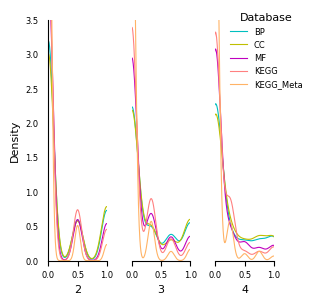

In [99]:
maxn = 5
final2['pop'] = final2['pop'].apply(lambda x: maxn if x >= maxn else x)
final2 = final2.sort_values(['cluster','annscore'], ascending=[True,False]).drop_duplicates(['cluster','db'])

plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

fig, axes = plt.subplots(1,3, figsize=(3.1, 3.1), 
    dpi=100, sharey=True)

# iterate for each database and assign them a color
for i, ax in zip(set(final2['pop']), axes):
    for db, col in zip(['P','C','F','K','Km'], 
                       [(0,0.75,0.75),(0.75,0.75,0),
                        (0.75,0,0.75),(1,0.5,0.5),
                        (1,0.7,0.4)]):
        
        d = final2[final2['db']==db][final2['pop']==i]
        d[db] = d['annscore']
        d.sort_values(db)[db].plot.kde(color=col, ax=ax)
    
    ax.spines[['top','right','left']].set_visible(False)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim(0,1)
    ax.tick_params(axis='y', which='both', left=False)
    
    ax.set_xlabel(i)
    if i == maxn:
        ax.set_xlabel('≥'+str(i))

axes[0].spines[['left']].set_visible(True)
axes[-1].spines[['bottom']].set_visible(True)
plt.ylim(0,3.5)
plt.xlim(0,1)

# plt.xlabel('prova')
plt.legend(['BP','CC','MF','KEGG','KEGG_Meta'], 
           loc=(0.2, 0.7), frameon=False, title='Database')

fig.tight_layout()
fig.savefig(f'{clusters_file}.annotationscore.densitysingle.{gosource}.{imgformat}', dpi=300)

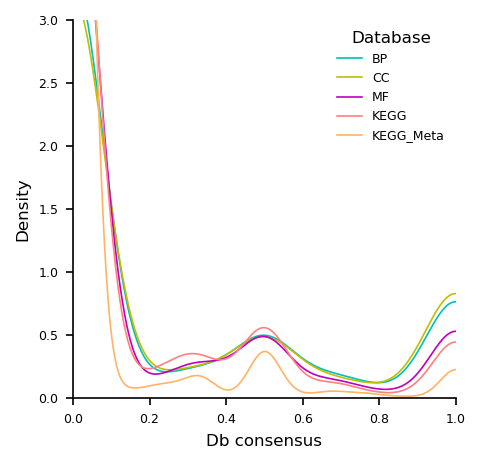

In [100]:
maxn = 5
final2['pop'] = final2['pop'].apply(lambda x: maxn if x >= maxn else x)
final2 = final2.sort_values(['cluster','annscore'], ascending=[True,False]).drop_duplicates(['cluster','db'])
final2 = final2.fillna(method='pad')

fig, axes = plt.subplots(1,1,figsize=(3.1,3.1), dpi=150, sharex=True)

# iterate for each database and assign them a color
for db, col in zip(['P','C','F','K','Km'], [(0,0.75,0.75),(0.75,0.75,0),(0.75,0,0.75),(1,0.5,0.5),(1,0.7,0.4)]):
    d = final2[final2['db']==db]
    d[db] = d['annscore']
    d.sort_values(db)[db].plot.kde(color=col, ax=axes)
axes.spines[['right','top']].set_visible(False)
plt.legend(['BP','CC','MF','KEGG','KEGG_Meta'], loc='upper right', frameon=False, title='Database')
axes.set_xlabel('Db consensus')
fig.tight_layout()
plt.ylim(0,3)
plt.xlim(0,1)
fig.savefig(f'{clusters_file}.annotationscore.densitysingle.{gosource}.{imgformat}', dpi=300)

In [101]:
cluss = []
for db in ['total','C','P','F','K','Km']:

    goslim2 = goslim.drop_duplicates(['og','goslimname']).groupby(['og','goslimtype'])['goslimname'].apply(list).reset_index()
    kegg2 = kegg.groupby(['og','type'])['featurename'].apply(list).reset_index()
    keggmeta2 = keggmeta.groupby(['og','type'])['featurename'].apply(list).reset_index()
    allfeat = pd.concat([goslim2.rename(columns={'goslimtype':'type','goslimname':'description'}),
               kegg2.rename(columns={'featurename':'description'}),
               keggmeta2.rename(columns={'featurename':'description'})])

    clusters2 = pd.merge(clusters, allfeat, how='outer').dropna(subset=['cluster'])

    clusters3 = clusters2.groupby(['cluster','n','og'])['type'].apply(list).reset_index()

    if db == 'total':
        clusters3['annotated'] = clusters3['type'].apply(lambda x: len([i for i in x if str(i)!='nan'])>0)
    else:
        clusters3['annotated'] = clusters3['type'].apply(lambda x: len([i for i in x if str(i)==db])>0)

    clusters4 = clusters3.groupby(['cluster','n'])['annotated'].sum().reset_index()
    clusters4['annratio'] = clusters4['annotated']/clusters4['n']
    clusters4['annratioscal'] = clusters4['annratio'].apply(lambda x: 
            # 1 if x == 1 else 0 if x == 0 else 0.33 if x<0.5 else 0.5 if x==0.5 else 0.66 if x>0.5 else None)
            1 if x == 1 else 0 if x == 0 else 0.5)
    # clusters4['annratioscal'].plot.hist(ylim=(0,2300), histtype='bar')

    clus = clusters4['annratioscal'].rename(db).reset_index()
    clus = clus.rename(columns={db:'score'})
    clus['db'] = db
    clus = clus.drop('index', axis=1)
    cluss.append(clus)
    
pp = pd.concat(cluss).groupby(['db','score'], sort=False)['db'].count().rename('counts').reset_index()

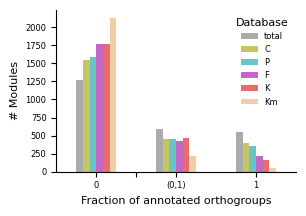

In [102]:
import seaborn as sns

plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

fig, ax = plt.subplots(1, figsize=(3.1, 2.2), dpi=100)

pp = pd.concat(cluss).groupby(['db','score'], sort=False)['db'].count().rename('counts').reset_index()
ax = sns.barplot(data=pp, x='score', y='counts', hue='db', width=0.5, alpha=0.66, palette=
                 ['gray',(0.75,0.75,0,0.66),(0,0.75,0.75,0.66),
                        (0.75,0,0.75,0.66),(1,0,0,0.66),
                        (1,0.7,0.4,0.66)])
plt.xticks([0,0.5,1,2], ['0','','(0,1)','1'])
plt.xlabel('Fraction of annotated orthogroups')
plt.ylabel('# Modules')
plt.legend(frameon=False, title='Database')
ax.spines[['top', 'right']].set_visible(False)
fig.tight_layout()
fig.savefig(f'{clusters_file}.annotationscore3.{gosource}.{imgformat}', dpi=150)

## Extra figure 7J

In [103]:
# plotting clusters with at least 50% of orthogroup annotated
clusters = pd.read_table(clusters_file)
scores = pd.read_table(scores_file)
perc_thr = 50

clusterslen = clusters.drop_duplicates('cluster').groupby('n')['cluster'].apply(len).reset_index().rename(columns={'n':'pop'})

dfs = [clusterslen]
# for d in ['P','C','F','K','Km','S']:
for d in ['P','C','F','K','Km']:
    scores['perc.ann'] = scores['pop.ann']*100/scores['pop']
    scoresann = scores[scores['db']==d][scores['perc.ann']>=perc_thr] # >= --> module size 2, 1 annotated og --> 0.5
    clusterslendb = scoresann.groupby('pop')['cluster'].apply(len).reset_index()
    clusterslendb = clusterslendb.rename(columns={'cluster':d})
    dfs.append(clusterslendb)
    
dfsmerg = reduce(lambda left, right: 
                   pd.merge(left, right,on=['pop'], how='outer'), dfs)
dfsmerg = dfsmerg.rename(columns={'pop':'clustersize', 'cluster':'count'})

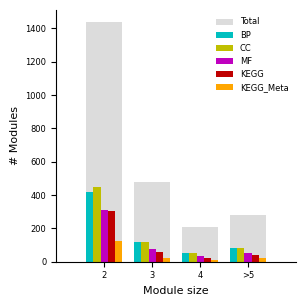

In [104]:
uplim = 5 # default 10
save = True

plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

dfsmerg1 = dfsmerg[dfsmerg['clustersize']<uplim]
dfsmerg1.loc[8] = [uplim]+dfsmerg[
    dfsmerg['clustersize']>=uplim].sum(axis=0).tolist()[1:]

fig, (ax2) = plt.subplots(1, 1, figsize=(3.1,3.1), 
                          dpi=100, sharex=True)

colorsfrommap = [plt.cm.jet(n)[0:3] for n in 
                 np.array(list(range(0,12)))/11]

for i in range(2, uplim+1):

    if i in set(dfsmerg1['clustersize']):
        n2 = dfsmerg1[dfsmerg1['clustersize']==i]

        ax2.bar(i, n2['count'].iloc[0],  0.75, label='Total', color='gainsboro')
        # ax2.bar(i-0.3, n2['S'].iloc[0],  0.15, label='String', color=(0.2,0.5,0.2,0.8))
        ax2.bar(i-0.3, n2['P'].iloc[0],  0.15, label='BP',        color=(0, 0.75, 0.75))
        ax2.bar(i-0.15, n2['C'].iloc[0],  0.15, label='CC',        color=(0.75,0.75,0)) 
        ax2.bar(i-0.0, n2['F'].iloc[0],  0.15, label='MF',        color=(0.75,0,0.75)) 
        ax2.bar(i+0.15, n2['K'].iloc[0],  0.15, label='KEGG',      color=(0.75, 0, 0))
        ax2.bar(i+0.3, n2['Km'].iloc[0], 0.15, label='KEGG_Meta', color=(1, 0.65, 0))

        plt.xlim(1, uplim+1)
        ax2.set_xticks(list(range(2, uplim+1)))
        labels = list(map(str, list(range(2, uplim+1))))
        labels[-1] = f'>{uplim}'
        ax2.set_xticklabels(labels)
        if i == 2:
            ax2.legend(loc='upper right', frameon=False)
        
ax2.spines['top'].set_visible(False)
ax2.xaxis.tick_bottom()
ax2.spines[['top', 'right']].set_visible(False)
ax2.set_xlabel('Module size')
ax2.set_ylabel('# Modules')

plt.subplots_adjust(hspace=0.1)

if save == True:
    fig.tight_layout()
    fig.savefig(f'{clusters_file}.distributions.{gosource}.{imgformat}', dpi=300)

## Figure 3D

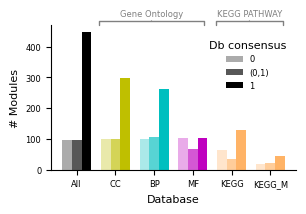

In [111]:
# plotting the scores for each cluster

plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

save = True

scores = pd.read_table(f'{clusters_file}.{gosource}.scores')
# DBC score
scores['pop.ann.perc'] = scores['pop.ann']/scores['pop']
scores = scores[scores['pop.ann.perc']>0.5] # at least 50% annotated og in each cluster
# scores = scores[scores['pop.ann']>=2]
scores = scores[~scores['mostfreq'].astype(str).str.contains('protein binding', case=False)]

ann = {'K': 'K', 'Km': 'KM', 'S': 'S', 'F': 'MF', 'P': 'BP', 'C': 'CC', 'All': 'All'}

df2 = pd.concat([pd.DataFrame([[ann.get(d), len(scores[scores['db']==d][scores['score']==1].drop_duplicates('cluster')), 's=1'],
                               [ann.get(d), len(scores[scores['db']==d][scores['score']==0].drop_duplicates('cluster')), 's=0'],
                               [ann.get(d), len(scores[scores['db']==d][(scores['score']>0)&(scores['score']<1)].drop_duplicates('cluster')), 's(0,1)'],]) 
                 for d in ['K','Km','S','P','C','F']])
df2.columns = ['type','count','slice']
df2 = df2.reset_index(drop=True)

s1 = scores.groupby('cluster')['score'].apply(list)
s2 = s1.apply(lambda x: 1 if 1 in x else 0 if x.count(0)==len(x) else 0.5)
s3 = pd.DataFrame([
    ['All','All','All'],
    ['s=1','s(0,1)','s=0'],
    [s2.tolist().count(1), s2.tolist().count(0.5), s2.tolist().count(0)],
]).T
s3.columns = ['type','slice','count']
s3 = pd.concat([df2, s3])

df2 = s3.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(3.1,2.2), dpi=100)
for e, (colo, typ) in enumerate(zip([(0,0,0),(0.75,0.75,0),(0,0.75,0.75),(0.75,0,0.75),(1,0.7,0.4),(1,0.7,0.4),], ['All','CC','BP','MF','K','KM'])):
    ax.bar(e-0.25, df2[df2['type']==typ][df2['slice']=='s=0']['count'], width=0.25, color=colo, alpha=0.33)
    ax.bar(e, df2[df2['type']==typ][df2['slice']=='s(0,1)']['count'], width=0.25, color=colo, alpha=0.66)
    ax.bar(e+0.25, df2[df2['type']==typ][df2['slice']=='s=1']['count'], width=0.25, color=colo, alpha=1)
    
ax.bar(0,0,0,color=(0,0,0,0.33),label='0')
ax.bar(0,0,0,color=(0,0,0,0.66),label='(0,1)')
ax.bar(0,0,0,color=(0,0,0,1),label='1')

ax.set_xlabel('Database')
ax.set_ylabel('# Modules')

ax.spines[['top','right']].set_visible(False)
ax.set_xticklabels(['-','All', 'CC','BP','MF','KEGG','KEGG_M'])
plt.legend(loc=(0.63,0.53), title='Db consensus', frameon=False)

ax.annotate('Gene Ontology', xy=(0.41, 1.03), xytext=(0.41, 1.05), xycoords='axes fraction', 
            fontsize=6, ha='center', va='bottom',color='gray',
            arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=0.5',color='gray', lw=1.0))

ax.annotate('KEGG PATHWAY', xy=(0.81, 1.03), xytext=(0.81, 1.05), xycoords='axes fraction', 
            fontsize=6, ha='center', va='bottom',color='gray',
            arrowprops=dict(arrowstyle='-[, widthB=4, lengthB=0.5',color='gray', lw=1.0))

fig.tight_layout()
fig.savefig(f'{clusters_file}.annotationscores.{gosource}.{imgformat}', dpi=300)

## Extra figure 7O

In [106]:
gopdict = dict(goslim[goslim['goslimtype']=='P'].groupby('og')['goslimname'].apply(list).reset_index().values.tolist())
gocdict = dict(goslim[goslim['goslimtype']=='C'].groupby('og')['goslimname'].apply(list).reset_index().values.tolist())
gofdict = dict(goslim[goslim['goslimtype']=='F'].groupby('og')['goslimname'].apply(list).reset_index().values.tolist())
kegdict = dict(kegg.groupby('og')['featurename'].apply(list).reset_index().values.tolist())
kegmdict = dict(keggmeta.groupby('og')['featurename'].apply(list).reset_index().values.tolist())
clusters['P'] = clusters['og'].apply(lambda x: gopdict.get(x))
clusters['C'] = clusters['og'].apply(lambda x: gocdict.get(x))
clusters['F'] = clusters['og'].apply(lambda x: gofdict.get(x))
clusters['K'] = clusters['og'].apply(lambda x: kegdict.get(x))
clusters['Km'] = clusters['og'].apply(lambda x: kegmdict.get(x))

dfs = []
for db in ['P','C','F','K','Km']:
    counts = clusters.groupby('cluster')[db].apply(list).apply(lambda x: [len(set(i)) if i else None for i in x])
    counts = counts.apply(lambda x: len(x)-x.count(None)).rename(db)
    dfs.append(counts)
dfs = pd.concat(dfs, 1).reset_index()


ndict = dict(clusters[['cluster','n']].values.tolist())
dfs['n'] = dfs['cluster'].apply(lambda x: ndict.get(x))
# dfs = dfs[dfs['n']!=2]

clusters['tot'] = clusters.iloc[:,6:].isnull().all(axis=1)
countnan = clusters.groupby('cluster')['tot'].apply(list).apply(lambda x: x.count(False))
countnan = countnan.apply(lambda x: 3 if x >= 3 else x).tolist()

counts = []
for db in ['P','C','F','K','Km']:
    counts.append([db, dfs[db].tolist().count(0), dfs[db].tolist().count(1), 
                   dfs[db].tolist().count(2), dfs[db].apply(lambda x: 3 if x >= 3 else x).tolist().count(3)])
counts.append(['All', countnan.count(0), countnan.count(1), countnan.count(2), countnan.count(3)])

counts = pd.DataFrame(counts)

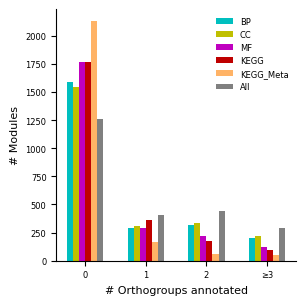

In [107]:
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

save = True

fig, ax = plt.subplots(figsize=(3.1,3.1))

for i, db in zip(range(6), counts[0].tolist()):
    try:
        lis = counts[i+1].tolist()
        ax.bar(i-0.25, lis[0], 0.1, label='P', color=(0,0.75,0.75))
        ax.bar(i-0.15, lis[1], 0.1, label='C', color=(0.75,0.75,0))
        ax.bar(i-0.05, lis[2], 0.1, label='F', color=(0.75,0,0.75))
        ax.bar(i+0.05, lis[3], 0.1, label='K', color=(0.75, 0, 0))
        ax.bar(i+0.15, lis[4], 0.1, label='Km', color=(1,0.7,0.4))
        ax.bar(i+0.25, lis[5], 0.1, label='All', color='gray')
    except:
        pass

plt.legend(['BP','CC','MF','KEGG','KEGG_Meta','All'], frameon=False)
ax.spines[['top','right']].set_visible(False)

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['0','1','2','≥3'])
ax.set_xlabel('# Orthogroups annotated')
ax.set_ylabel('# Modules')

if save == True:
    fig.tight_layout()
    fig.savefig(f'{clusters_file}.orthogroupsannotated.{gosource}.{imgformat}', dpi=300)

## Figure 3C

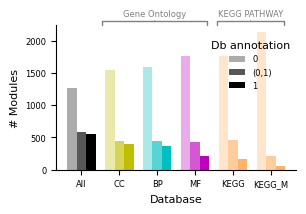

In [110]:
## plotting the scores for each cluster

plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

save = True

cluss = []
for db in ['total','C','P','F','K','Km']:

    goslim2 = goslim.drop_duplicates(['og','goslimname']).groupby(['og','goslimtype'])['goslimname'].apply(list).reset_index()
    kegg2 = kegg.groupby(['og','type'])['featurename'].apply(list).reset_index()
    keggmeta2 = keggmeta.groupby(['og','type'])['featurename'].apply(list).reset_index()
    allfeat = pd.concat([goslim2.rename(columns={'goslimtype':'type','goslimname':'description'}),
               kegg2.rename(columns={'featurename':'description'}),
               keggmeta2.rename(columns={'featurename':'description'})])

    clusters2 = pd.merge(clusters, allfeat, how='outer').dropna(subset=['cluster'])

    clusters3 = clusters2.groupby(['cluster','n','og'])['type'].apply(list).reset_index()

    if db == 'total':
        clusters3['annotated'] = clusters3['type'].apply(lambda x: len([i for i in x if str(i)!='nan'])>0)
    else:
        clusters3['annotated'] = clusters3['type'].apply(lambda x: len([i for i in x if str(i)==db])>0)

    clusters4 = clusters3.groupby(['cluster','n'])['annotated'].sum().reset_index()
    clusters4['annratio'] = clusters4['annotated']/clusters4['n']
    clusters4['annratioscal'] = clusters4['annratio'].apply(lambda x: 
            # 1 if x == 1 else 0 if x == 0 else 0.33 if x<0.5 else 0.5 if x==0.5 else 0.66 if x>0.5 else None)
            1 if x == 1 else 0 if x == 0 else 0.5)
    # clusters4['annratioscal'].plot.hist(ylim=(0,2300), histtype='bar')

    clus = clusters4['annratioscal'].rename(db).reset_index()
    clus = clus.rename(columns={db:'score'})
    clus['db'] = db
    clus = clus.drop('index', axis=1)
    cluss.append(clus)
    
pp = pd.concat(cluss).groupby(['db','score'], sort=False)['db'].count().rename('counts').reset_index()
pp['score'] = pp['score'].apply(lambda x: 's=0' if x == 0 else 's=1' if x==1 else 's(0,1)')
pp.columns = ['type','slice','count']
ann = {'K': 'K', 'Km': 'KM', 'S': 'S', 'F': 'MF', 'P': 'BP', 'C': 'CC', 'total': 'All'}
pp['type'] = pp['type'].apply(lambda x: ann.get(x))
df2 = pp

fig, ax = plt.subplots(figsize=(3.1,2.2), dpi=100)
for e, (colo, typ) in enumerate(zip([(0,0,0),(0.75,0.75,0),(0,0.75,0.75),(0.75,0,0.75),(1,0.7,0.4),(1,0.7,0.4),], ['All','CC','BP','MF','K','KM'])):
    ax.bar(e-0.25, df2[df2['type']==typ][df2['slice']=='s=0']['count'], width=0.25, color=colo, alpha=0.33)
    ax.bar(e, df2[df2['type']==typ][df2['slice']=='s(0,1)']['count'], width=0.25, color=colo, alpha=0.66)
    ax.bar(e+0.25, df2[df2['type']==typ][df2['slice']=='s=1']['count'], width=0.25, color=colo, alpha=1)
    
ax.bar(0,0,0,color=(0,0,0,0.33),label='0')
ax.bar(0,0,0,color=(0,0,0,0.66),label='(0,1)')
ax.bar(0,0,0,color=(0,0,0,1),label='1')

ax.set_xlabel('Database')
ax.set_ylabel('# Modules')

ax.spines[['top','right']].set_visible(False)
ax.set_xticklabels(['-','All', 'CC','BP','MF','KEGG','KEGG_M'])
plt.legend(loc=(0.63,0.53), title='Db annotation', frameon=False)

ax.annotate('Gene Ontology', xy=(0.41, 1.03), xytext=(0.41, 1.05), xycoords='axes fraction', 
            fontsize=6, ha='center', va='bottom',color='gray',
            arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=0.5',color='gray', lw=1.0))

ax.annotate('KEGG PATHWAY', xy=(0.81, 1.03), xytext=(0.81, 1.05), xycoords='axes fraction', 
            fontsize=6, ha='center', va='bottom',color='gray',
            arrowprops=dict(arrowstyle='-[, widthB=4, lengthB=0.5',color='gray', lw=1.0))

fig.tight_layout()
fig.savefig(f'{clusters_file}.annotationscores_prova.{gosource}.{imgformat}', dpi=300)